## Loading in and checking the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Flatten, Conv2D, MaxPool2D
from keras.optimizers import adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


Using plaidml.keras.backend backend.


In [2]:
train_data = np.load('./datasets/aug_data_obj.npy')
train_label = np.load('./datasets/aug_labels_obj.npy')
test_data = pd.read_csv('./datasets/test.csv')
train_data = pd.DataFrame(train_data)
train_label = pd.DataFrame(train_label)

## Splitting the data and its label

In [3]:
train_data = train_data / 255.0
test_data = test_data / 255.0

In [4]:
train_data = train_data.values.reshape(-1,28,28,1)
test_data = test_data.values.reshape(-1,28,28,1)

In [5]:
train_label = to_categorical(train_label, num_classes=10)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.002, stratify=train_label)
train_data=None

## Checking the image quality of a random value

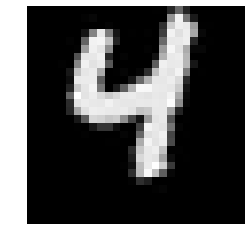

In [7]:
some_digit = X_train[2000]
some_digit_image = some_digit[:,:,0]

plt.imshow(some_digit_image, interpolation='nearest', cmap='gray')

plt.axis('off')
plt.show()


## Create Swish Activation Function

swish(x) = x * sigmoid(beta * x)

In [8]:
from keras.backend import sigmoid
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

get_custom_objects().update({'swish': Activation(swish)})

# Attempting to solve using a CNN

In [9]:
model = Sequential()

get_custom_objects().update({'swish': Activation(swish )})

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='swish', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='swish'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='swish'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='swish'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(256, activation = "swish"))
model.add(BatchNormalization())
model.add(Dense(100, activation = "swish"))

model.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = adam(lr=0.001,  epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

INFO:plaidml:Opening device "metal_amd_radeon_vega_frontier_edition.0"


In [10]:
from keras.callbacks import EarlyStopping

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

early_stopping = EarlyStopping(patience=10, min_delta=0.0001, restore_best_weights=True)

epochs = 500
batch_size = 1024

## Generating more data!

In [11]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [12]:
datagen.fit(X_train)

In [13]:
import scipy.ndimage
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,y_test),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction, early_stopping])

Epoch 1/500


INFO:plaidml:Analyzing Ops: 446 of 677 operations complete


 - 708s - loss: 0.0828 - acc: 0.9745 - val_loss: 0.0535 - val_acc: 0.9810
Epoch 2/500
 - 691s - loss: 0.0245 - acc: 0.9921 - val_loss: 0.0186 - val_acc: 0.9929
Epoch 3/500
 - 691s - loss: 0.0178 - acc: 0.9943 - val_loss: 0.0262 - val_acc: 0.9929
Epoch 4/500
 - 691s - loss: 0.0144 - acc: 0.9954 - val_loss: 0.0268 - val_acc: 0.9914
Epoch 5/500
 - 691s - loss: 0.0120 - acc: 0.9961 - val_loss: 0.0131 - val_acc: 0.9952
Epoch 6/500
 - 691s - loss: 0.0107 - acc: 0.9966 - val_loss: 0.0512 - val_acc: 0.9824
Epoch 7/500
 - 691s - loss: 0.0094 - acc: 0.9970 - val_loss: 0.0185 - val_acc: 0.9933
Epoch 8/500
 - 690s - loss: 0.0084 - acc: 0.9973 - val_loss: 0.1068 - val_acc: 0.9662

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 9/500
 - 691s - loss: 0.0048 - acc: 0.9985 - val_loss: 0.0078 - val_acc: 0.9967
Epoch 10/500
 - 691s - loss: 0.0040 - acc: 0.9987 - val_loss: 0.0028 - val_acc: 0.9995
Epoch 11/500
 - 691s - loss: 0.0039 - acc: 0.9987 - val_loss: 0.0028 -

## Building our results

In [14]:
results = model.predict(test_data)

In [15]:
results = np.argmax(results,axis = 1)

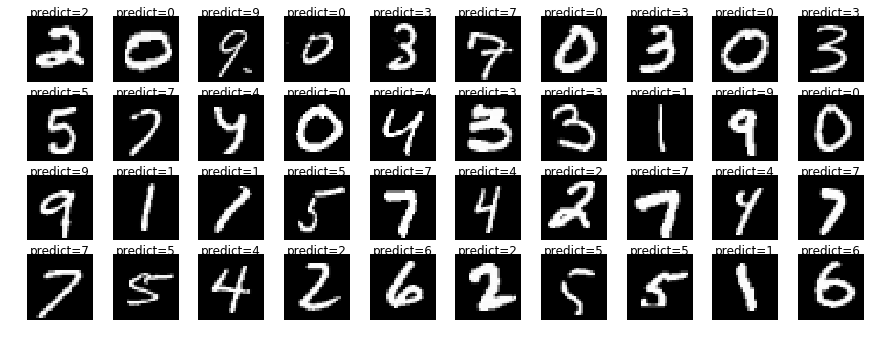

In [16]:
# Preview predictions
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(test_data[i][:,:,0], cmap='gray')
    plt.title("predict=%d" % results[i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

In [17]:
# Exporting our results for Kaggle
df = pd.DataFrame(results)
df.index.name='ImageId'
df.index+=1
df.columns=['Label']
df.to_csv('./datasets/results.csv', header=True)